# Comprehensive Multioutput Regression Pipeline with Multiple Model Comparison and Deployment


This notebook demonstrates a complete workflow for a multi-output regression model focused on predicting crop yields (`yield_min` and `yield_max`). It includes:
1. Feature Selection
2. Train-Test Split
3. Model Selection & Cross-Validation
4. Hyperparameter Tuning using Grid Search
5. Comparison of Multiple Multi-output Regression Models
6. Retraining the Best Model with optimal parameters
7. Model Testing and Evaluation
8. Model Inference
9. Model Deployment using Flask

---


## Step 1: Load and Inspect the Data

In [1]:
from google.colab import files
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor


In [2]:
# Load dataset
# Upload the file
uploaded = files.upload()


Saving Modified_Final (1).csv to Modified_Final (1).csv


In [3]:
data = pd.read_csv('Modified_Final (1).csv')
#file_path = '/mnt/data/Modified_Final.csv'  # Adjust the file path as needed
#data = pd.read_csv(file_path)

# Display first few rows and check for missing values
display(data.head())
print("Missing Values:", data.isnull().sum().any())

,yield_min,yield_max,Temperature,Avg Precipitation,Re Humidity,Nitrogen,Phosphorus,Potassium,Soil pH
0,2400,2600,26.140742,202.570087,85.314850,0.006653,0.004330,0.003934,6.129730
1,3000,3200,26.276687,211.789958,84.481911,0.007532,0.005381,0.003593,7.018127
2,3400,3600,26.105642,206.257218,85.551527,0.006808,0.004230,0.003883,5.941900
3,3600,3800,26.428816,189.775536,84.828606,0.007981,0.003476,0.004405,7.018250
4,2800,3000,25.967928,209.913964,85.524984,0.006757,0.004335,0.003896,6.002954


Missing Values: False


In [ ]:
print(data.columns)

Index(['yield_min', 'yield_max', 'Temperature', 'Avg Precipitation',
       'Re Humidity', 'Nitrogen ', 'Phosphorus', 'Potassium', 'Soil pH'],
      dtype='object')


## Step 2: Feature Engineering

In [4]:
# Feature Engineering: Adding 'yield_range' and 'yield_avg'
#data['yield_range'] = data['yield_max'] - data['yield_min']
data['yield_avg'] = (data['yield_min'] + data['yield_max']) / 2
display(data.head())


,yield_min,yield_max,Temperature,Avg Precipitation,Re Humidity,Nitrogen,Phosphorus,Potassium,Soil pH,yield_avg
0,2400,2600,26.140742,202.570087,85.314850,0.006653,0.004330,0.003934,6.129730,2500.0
1,3000,3200,26.276687,211.789958,84.481911,0.007532,0.005381,0.003593,7.018127,3100.0
2,3400,3600,26.105642,206.257218,85.551527,0.006808,0.004230,0.003883,5.941900,3500.0
3,3600,3800,26.428816,189.775536,84.828606,0.007981,0.003476,0.004405,7.018250,3700.0
4,2800,3000,25.967928,209.913964,85.524984,0.006757,0.004335,0.003896,6.002954,2900.0


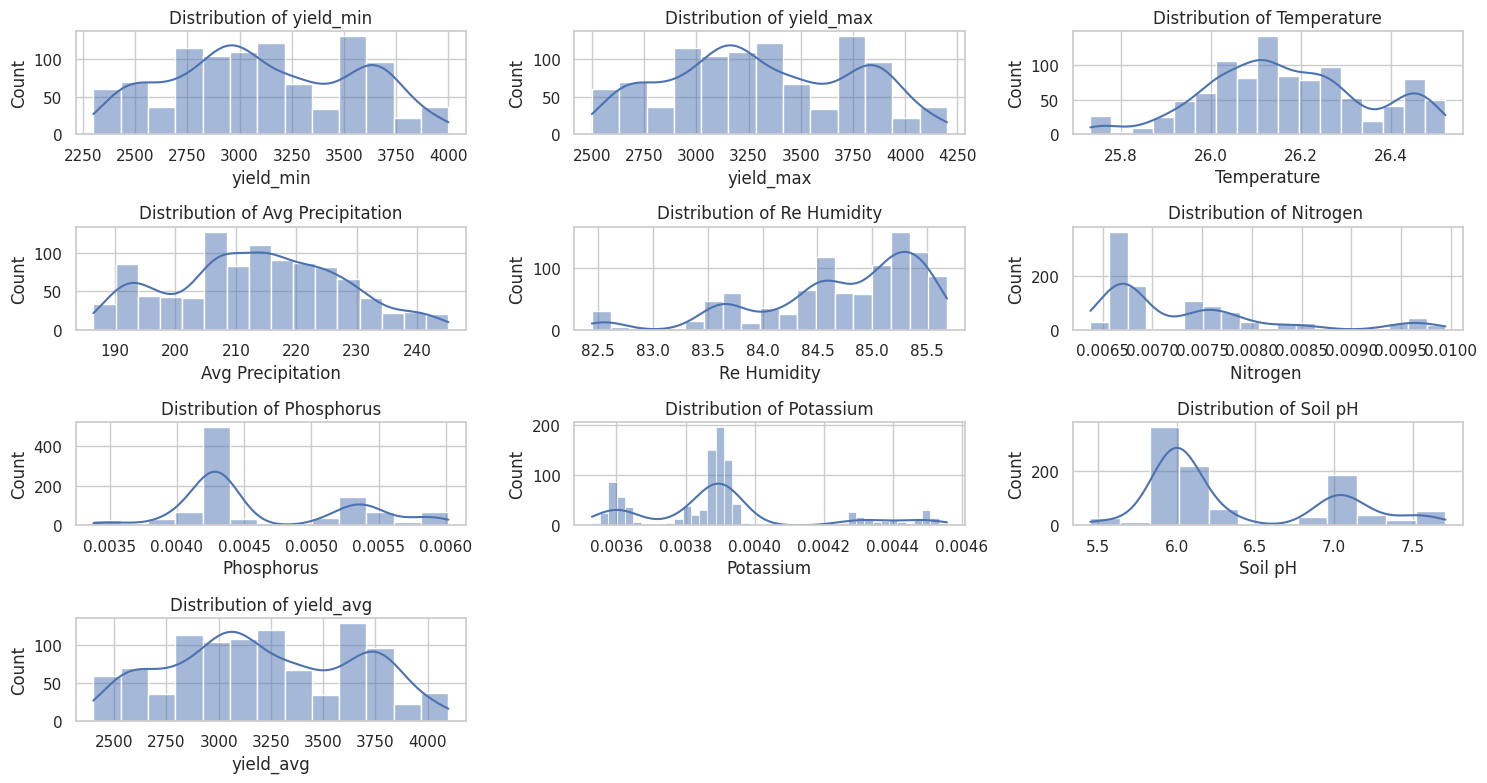

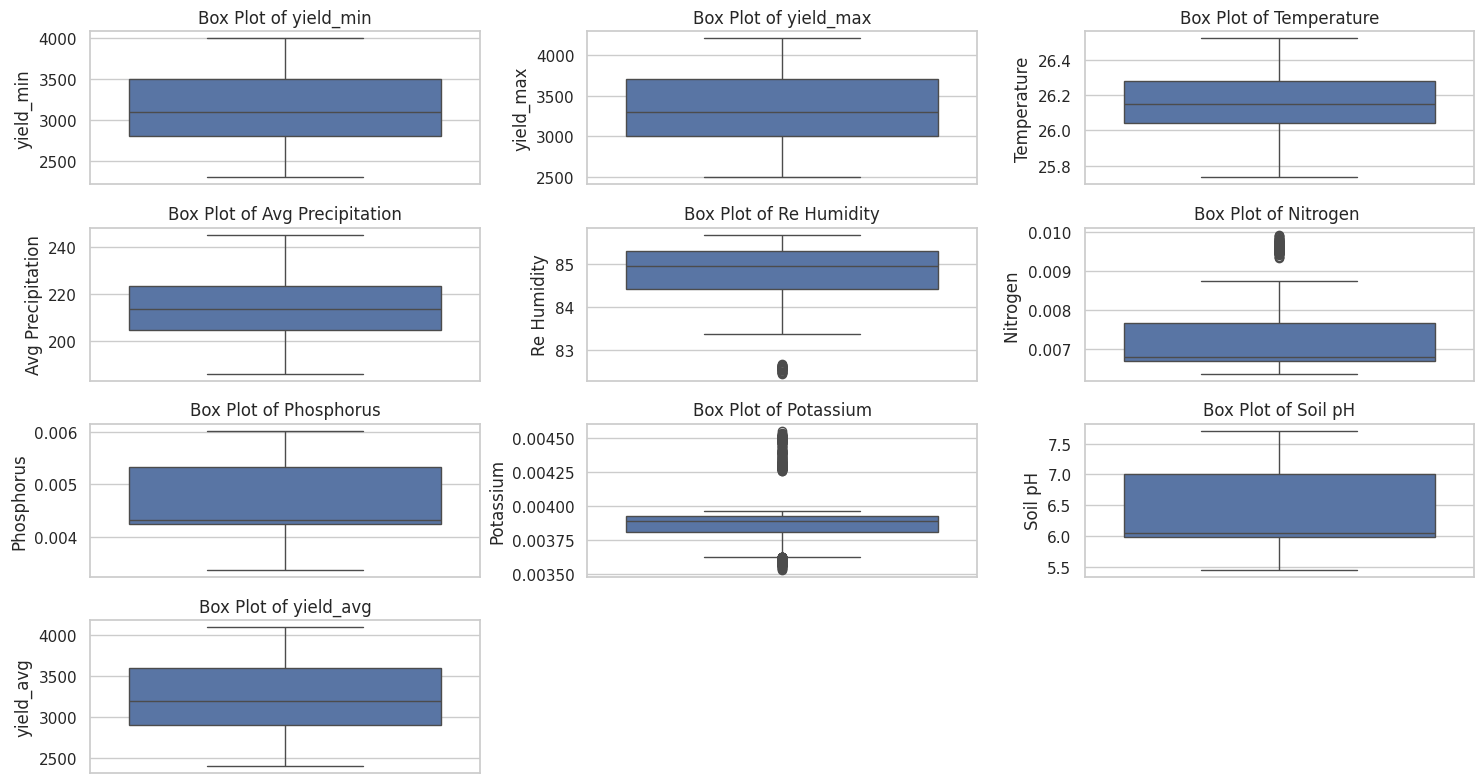

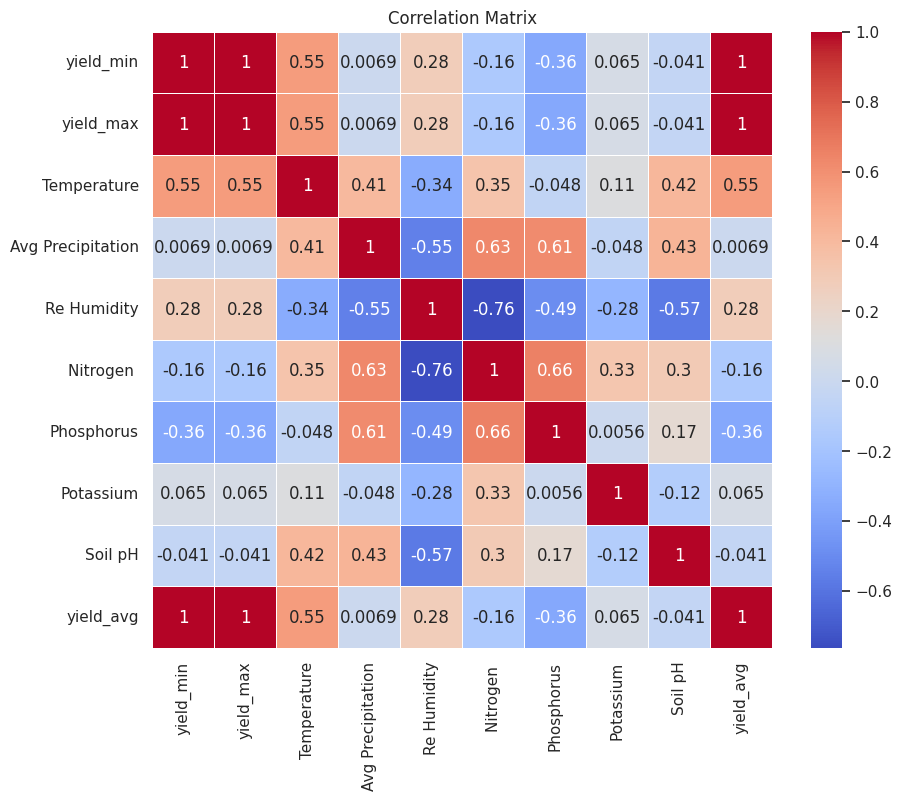

In [5]:
# Convert to DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# 1. Distribution Plots
plt.figure(figsize=(15, 8))
# Calculate the number of rows and columns for the subplots
num_cols = 3  # Number of columns
num_rows = int(np.ceil(len(df.columns) / num_cols)) # Number of rows, adjusted for extra columns

for i, column in enumerate(df.columns, 1):
    plt.subplot(num_rows, num_cols, i) # Adjust subplot grid
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# 2. Box Plots
plt.figure(figsize=(15, 8))
# Calculate the number of rows and columns for the subplots
num_cols = 3  # Number of columns
num_rows = int(np.ceil(len(df.columns) / num_cols)) # Number of rows, adjusted for extra columns
for i, column in enumerate(df.columns, 1):
    plt.subplot(num_rows, num_cols, i)  # Adjust subplot grid
    sns.boxplot(y=df[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

# 3. Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

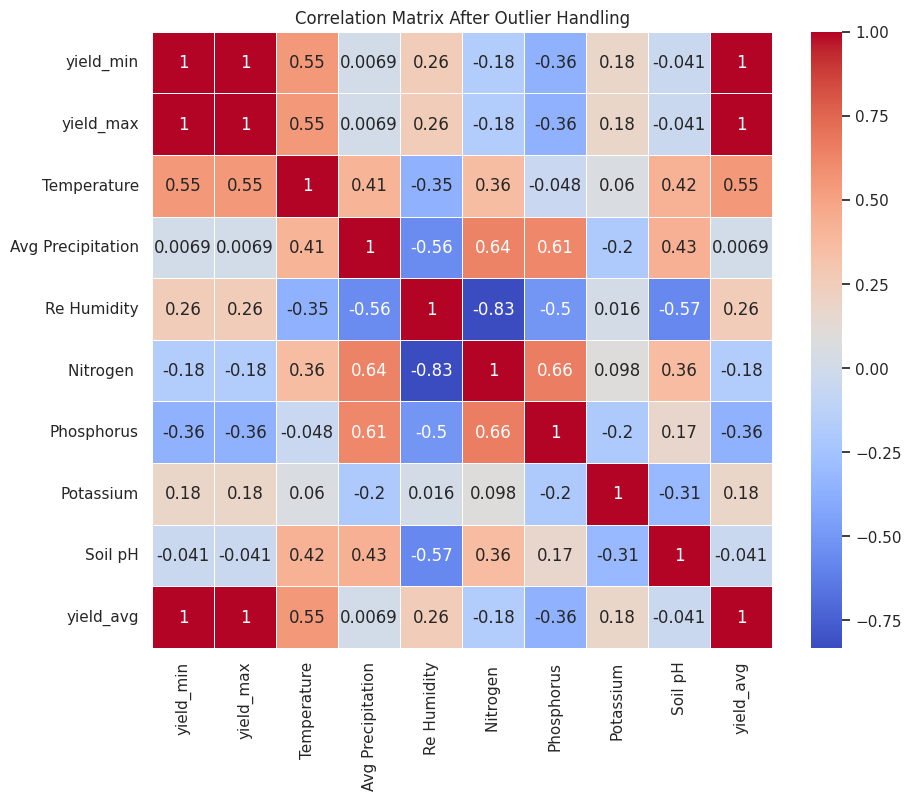

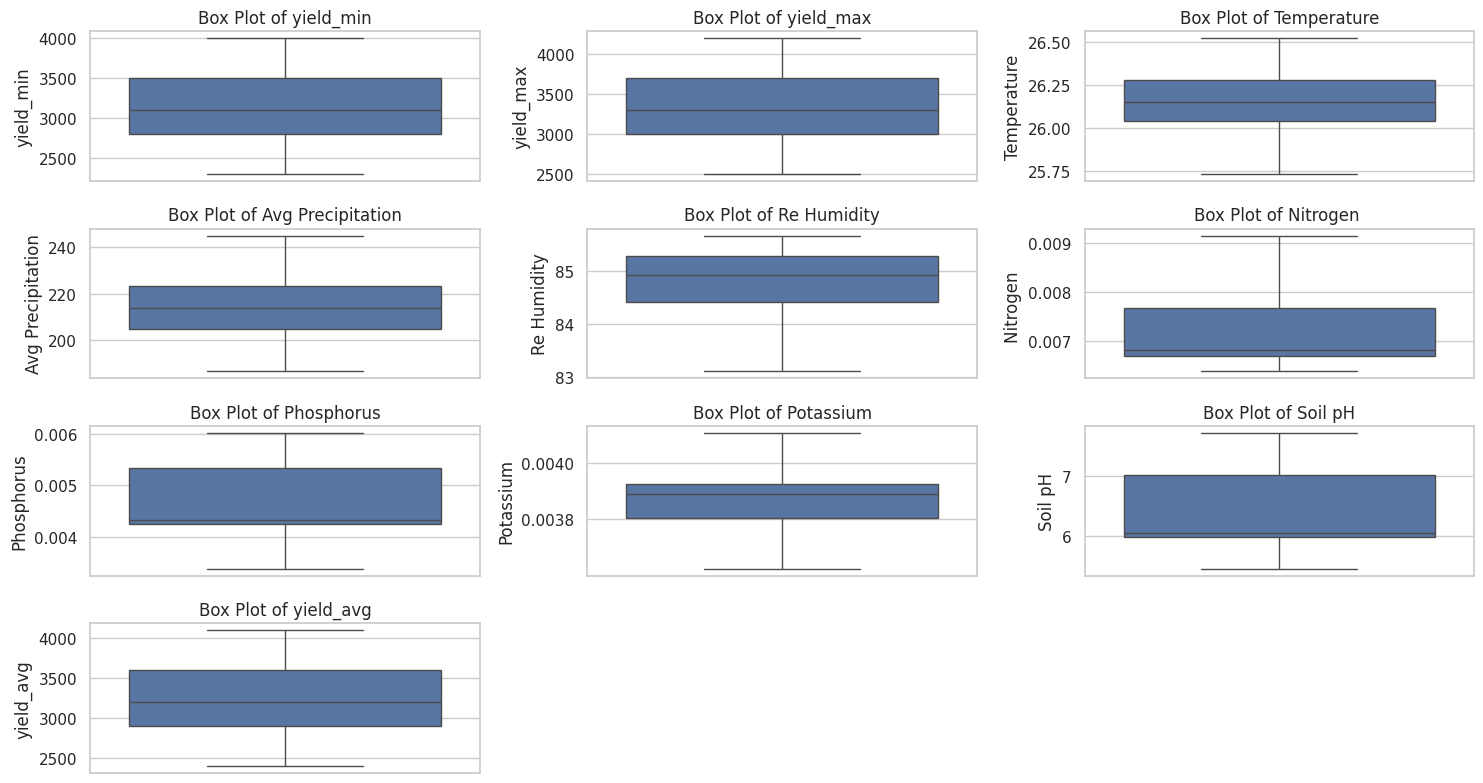

In [6]:
# Outlier handling using IQR
def handle_outliers(df):
    df_out = df.copy()
    for column in df_out.columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df_out[column].quantile(0.25)
        Q3 = df_out[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with the bounds
        df_out[column] = df_out[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)
    return df_out

# Apply outlier handling
df_cleaned = handle_outliers(df)

# Check correlation matrix after outlier handling
plt.figure(figsize=(10, 8))
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix After Outlier Handling")
plt.show()

# Box Plots
plt.figure(figsize=(15, 8))
# Calculate the number of rows and columns for the subplots
num_cols = 3  # Number of columns
num_rows = int(np.ceil(len(df.columns) / num_cols)) # Number of rows, adjusted for extra columns
for i, column in enumerate(df_cleaned.columns, 1):
    plt.subplot(num_rows, num_cols, i)  # Adjust subplot grid
    sns.boxplot(y=df_cleaned[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

In [ ]:
print(df_cleaned.columns)

Index(['yield_min', 'yield_max', 'Temperature', 'Avg Precipitation',
       'Re Humidity', 'Nitrogen ', 'Phosphorus', 'Potassium', 'Soil pH',
       'yield_avg'],
      dtype='object')


## Step 3: Feature Selection

In [7]:

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

# Define features and target labels
X = df_cleaned[['Temperature', 'Avg Precipitation', 'Re Humidity', 'Nitrogen ', 'Phosphorus', 'Potassium', 'Soil pH']]
y = df_cleaned[['yield_min', 'yield_max']]

# Perform feature selection using Recursive Feature Elimination with Cross-Validation (RFECV)
selector = RFECV(estimator=RandomForestRegressor(random_state=42), step=1, cv=5)
selector.fit(X, y)

# Display selected features
selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)
X_selected = X[selected_features]  # Retain only selected features


Selected Features: Index(['Temperature', 'Avg Precipitation', 'Re Humidity', 'Phosphorus'], dtype='object')


In [8]:
# Swap X_selected and y
X_selected, y = y, X_selected


# Now, X_selected contains the previous 'y' values, and 'y' contains the previous 'X_selected' values.
print("New X (Selected Features):", X_selected.columns)
print("New y (Target Labels):", y.columns)

New X (Selected Features): Index(['yield_min', 'yield_max'], dtype='object')
New y (Target Labels): Index(['Temperature', 'Avg Precipitation', 'Re Humidity', 'Phosphorus'], dtype='object')


## Step 4: Train-Test Split

In [9]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,  MinMaxScaler

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print("Training and test sets created.")

# Scale features
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

Training and test sets created.


In [10]:
X_train_df = pd.DataFrame(X_train, columns=[f"Feature_{i}" for i in range(X_train.shape[1])])
# Use generic column names based on the number of features in X_train
print(X_train_df.head())

   Feature_0  Feature_1
0   1.111700   1.111700
1  -1.693115  -1.693115
2   0.877966   0.877966
3   1.345435   1.345435
4  -1.693115  -1.693115


## Step 5: Model Selection & Cross-Validation

In [11]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# Initialize multiple models
models = {
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(random_state=42)),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "K-Neighbors": MultiOutputRegressor(KNeighborsRegressor()),
    "Linear Regression": MultiOutputRegressor(LinearRegression())
}

# Define the scoring metrics
scoring = {
    'r2': make_scorer(r2_score),
    'mse': make_scorer(mean_squared_error)
}

# Perform cross-validation for each model and store mean R² and MSE scores
results = {}
for model_name, model in models.items():
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    mean_r2 = np.mean(cv_results['test_r2'])
    mean_mse = np.mean(cv_results['test_mse'])
    results[model_name] = {'mean_r2': mean_r2, 'mean_mse': mean_mse}

    # Print the results for each model
    print(f"{model_name} Mean Cross-Validation R² Score: {mean_r2:.4f}")
    print(f"{model_name} Mean Cross-Validation MSE Score: {mean_mse:.4f}\n")

# Identify the best model based on R² score
best_model_name = max(results, key=lambda x: results[x]['mean_r2'])
best_model = models[best_model_name]
print(f"Best model based on R² score: {best_model_name} with R² Score: {results[best_model_name]['mean_r2']:.4f} and MSE: {results[best_model_name]['mean_mse']:.4f}")



Random Forest Mean Cross-Validation R² Score: 0.3133
Random Forest Mean Cross-Validation MSE Score: 0.6828

Gradient Boosting Mean Cross-Validation R² Score: 0.3131
Gradient Boosting Mean Cross-Validation MSE Score: 0.6830

K-Neighbors Mean Cross-Validation R² Score: 0.2100
K-Neighbors Mean Cross-Validation MSE Score: 0.7856

Linear Regression Mean Cross-Validation R² Score: 0.1090
Linear Regression Mean Cross-Validation MSE Score: 0.8879

Best model based on R² score: Random Forest with R² Score: 0.3133 and MSE: 0.6828


## Step 6: Hyperparameter Tuning using Grid Search

In [12]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# Define the scoring metrics
scoring = {
    'r2': make_scorer(r2_score, multioutput='uniform_average'),  # Average R² across targets
    'mse': make_scorer(mean_squared_error, multioutput='uniform_average')  # Average MSE across targets
}

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

# Initialize the base model with GridSearchCV for hyperparameter tuning
base_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Perform cross-validation with both R² and MSE as scoring metrics on the best model
cv_results = cross_validate(best_model, X_train, y_train, cv=5, scoring=scoring)

# Extract individual R² and MSE scores for each fold
r2_scores = cv_results['test_r2']
mse_scores = cv_results['test_mse']

# Define the target labels
target_labels = ['Temperature', 'Avg Precipitation', 'Re Humidity', 'Phosphorus']

# Calculate and print the mean R² and MSE scores across all folds
mean_r2 = np.mean(r2_scores)
mean_mse = np.mean(mse_scores)
print("Best Parameters:", grid_search.best_params_)
print(f"\nMean R² score across all outputs: {mean_r2:.4f}")
print(f"Mean MSE score across all outputs: {mean_mse:.4f}")


Best Parameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}

Mean R² score across all outputs: 0.3135
Mean MSE score across all outputs: 0.6828



## Step 7: Testing

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming best_model has already been trained
# X_test and y_test are the test set features and labels, respectively

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate R² and MSE for each output
r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
mse_scores = mean_squared_error(y_test, y_pred, multioutput='raw_values')

# Define the target labels
target_labels = ['Temperature', 'Avg Precipitation', 'Re Humidity', 'Phosphorus', 'Nitrogen ', 'Potassium', 'Soil pH' ]

# Print R² and MSE for each target
print("Test R² and MSE scores for each output:")
for label, r2, mse in zip(target_labels, r2_scores, mse_scores):
    print(f"{label} - R²: {r2:.4f}, MSE: {mse:.4f}")

# Calculate and print the mean R² and MSE across all outputs
mean_r2 = np.mean(r2_scores)
mean_mse = np.mean(mse_scores)
print(f"\nMean Test R² score across all outputs: {mean_r2:.4f}")
print(f"Mean Test MSE score across all outputs: {mean_mse:.4f}")


Test R² and MSE scores for each output:
Temperature - R²: 0.3975, MSE: 0.0197
Avg Precipitation - R²: 0.2955, MSE: 123.0963
Re Humidity - R²: 0.3851, MSE: 0.2861
Phosphorus - R²: 0.2945, MSE: 0.0000
Nitrogen  - R²: 0.1868, MSE: 0.0000
Potassium - R²: 0.0867, MSE: 0.0000
Soil pH - R²: 0.3109, MSE: 0.2398

Mean Test R² score across all outputs: 0.2796
Mean Test MSE score across all outputs: 17.6631


## Step 8: Model Inference Example

In [ ]:
# Example new data point(s) for prediction (1 sample with 3 features as per your feature set)
# Ensure that 'yield_min', 'yield_max', and 'yield_avg' are within the expected range
new_data = np.array([[2400.0, 2600.0, 2500.0]])  # Replace these values with realistic feature values

# Make prediction on new data
prediction = best_model.predict(new_data)

# Print the predictions for each output label
print("Predictions for new data:")
for label, pred in zip(target_labels, prediction[0]):
    print(f"{label}: {pred:.4f}")


Predictions for new data:
Temperature: 26.4698
Avg Precipitation: 220.6372
Re Humidity: 83.7631
Phosphorus: 0.0040
Nitrogen : 0.0078
Potassium: 0.0038
Soil pH: 7.5320


## Step 9: Model Deployment

In [ ]:
# Save the trained model using joblib
import joblib

# Save the model to a file
joblib.dump(best_model, "multioutput_regression_model.pkl")
joblib.dump(selector, "feature_selector.pkl")
print("Model and selector saved for deployment.")

Model and selector saved for deployment.


## Step 11: Model Deployment using Flask

In [ ]:

# Save the trained model using joblib
import joblib

# Save the model to a file
joblib.dump(best_model, "multioutput_regression_model.pkl")
joblib.dump(selector, "feature_selector.pkl")
print("Model and selector saved for deployment.")


In [ ]:

# Flask application code for deployment
from flask import Flask, request, jsonify
import joblib
import numpy as np

# Load the trained model and feature selector
model = joblib.load("multioutput_regression_model.pkl")
selector = joblib.load("feature_selector.pkl")

# Initialize Flask app
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # Parse input JSON data
    data = request.json
    features = np.array([data['features']])  # Expects a list of feature values

    # Select relevant features and make prediction
    selected_features = features[:, selector.support_]
    prediction = model.predict(selected_features).tolist()

    # Return prediction as JSON
    return jsonify({'yield_min': prediction[0][0], 'yield_max': prediction[0][1]})

if __name__ == '__main__':
    app.run(debug=True)
